In [2]:
## IMPORTS

import os
import sys
import time
import math
from datetime import datetime
from io import StringIO


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from numpy.polynomial.polynomial import Polynomial
import scipy.integrate as integrate
import scipy.optimize as sco
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
import openpyxl
import networkx as nx
import sklearn.metrics
from IPython.core.display import HTML
import plotly.io as pio
from openpyxl.utils.dataframe import dataframe_to_rows
import openpyxl as opxl
import matplotlib.ticker as mtick
from matplotlib.cm import get_cmap
import time


sys.path.append(r'D:\seagu_OneDrive\Documents\GitHub\parallel-flow-distribution-pressure-loss\ansys')
sys.path.append(r'D:\seagu_OneDrive\Documents\GitHub\PVT-thermal-performance-model')
import jou_gen as jg
import ansys_py_bridge as apb
import ansys.fluent.core as pyfluent
import model as ty
import proc as pr
import plot_functions_here as pfun
import heat_transfer as bht
import fluids as fds
import ht
import general as gen

# Initialisation

In [3]:
## Importation des données excel

# folder_path_model = r'G:\Drive partagés\Cercle Hard\R&D\Modèles numériques PVT\PVT-perf-1Dmodel'
# # geometry_path = folder_path_model + '\\' + 'Panels\\Inputs_TEST_V4.5_GG.xlsx'
# # hypotheses_path = folder_path_model + '\\' + 'Hypotheses\\Model_hypotheses.xlsx'
# # condi_path = folder_path_model + '\\' + 'Steady-state conditions inputs\\100424-tests-conditions-GMI.xlsx'
# # folder_path_ansys = r'D:\ANSYS Fluent Projects\pvt_slice_outdoor\Fluent_GMI'

folder_path = r'D:\ANSYS Fluent Projects\pvt_slice_outdoor\Fluent_GMI\tests'
geometry_path = folder_path + '\\' + 'Inputs_TEST_V4.5_GG.xlsx'
hypotheses_path = folder_path + '\\' + 'Model_hypotheses.xlsx'
condi_path = folder_path + '\\' + 'test-Conditions-AR.xlsx'
folder_path_ansys = r'D:\ANSYS Fluent Projects\pvt_slice_outdoor\Fluent_GMI'

report_path = folder_path

panelSpecs = pr.import_geometry(geometry_path)
hyp = pr.create_dict_from_excel(hypotheses_path,'Main')
steadyStateConditions_df = pd.read_excel(condi_path,header=2) ## Les deux première lignes ne sont pas à prendre
stepConditions = steadyStateConditions_df.to_dict(orient='records')

Inputs = pd.read_excel(folder_path + '\\' + 'Inputs_PyFluent.xlsx')

case = 1 # On utilise le cas 61 de steadyStateConditions

nb_hx = int(apb.get_value('nb_hx','named_expression', Inputs))
big_it = hyp['big_it']
T_amb = stepConditions[case]['T_amb']

file_path_result_CFD = hyp['CFD_ht_path']+f'_{big_it}.csv' ## On ne peut pas l'appeler autrement pour le moment, il y a un appel dans la fonction simu_on_steadyState
file_path_result_1D = hyp['CFD_ht_path']+'_1D' + f'_{big_it}.csv'
file_path_result_Inputs = hyp['CFD_ht_path']+'_Inputs' + f'_{big_it}.csv'
file_path_result_CFD_Qdot = hyp['CFD_ht_path']+'_CFD_Qdot' + f'_{big_it}.csv'

In [8]:
T_fluid_in0 = stepConditions[case]['T_fluid_in0']
theta = apb.get_value('theta', 'named_expression', Inputs)
L_abs = panelSpecs['main']['L_abs']
c = bht.speed_natural_convection(T_fluid_in0, T_amb, theta,L_abs)
c

6.700771052237347e-05

In [ ]:
## Initialisation

# File > Application > Start > folder_path_ansys
# Ensuite copier le numéro du server et le modifier ci-dessous
solver_path = folder_path_ansys + '\\server\\' + 'server_info-13112.txt'
# Créer une session
solver = pyfluent.connect_to_fluent(server_info_file_name=solver_path)
tui = solver.tui

Création des variables sur ANSYS // une fois qu'elle est faite ne plus y toucher

In [ ]:
## Création des expression sur PyFluent

for i in range(len(Inputs)):
    named_expression = Inputs.iloc[i]['named_expression']
    value = Inputs.iloc[i]['value']
    unit = Inputs.iloc[i]['unit']
    if pd.isna(unit) :
        jg.create_field(tui, named_expression, value)
    else :
        jg.create_named_expression(tui, named_expression, value, unit)
    print(str(100*i/len(Inputs)) + "% des expressions créées")

print('Expressions importées')

In [ ]:
## Initialisation des champs des températures et des températures moyennes

# Créé un champ de température pour toutes les parties de l'échangeur
y0, z0 = 0, 0
for i in range(1, nb_hx+1) :
    theta_i = apb.get_value(f'theta_{i}', 'named_expression', Inputs)
    #theta_i = np.deg2rad(theta_i)
    L_i = apb.get_value(f'L_{i}', 'named_expression', Inputs)
    jg.create_field(tui, f'T_field_{i}', f"(T_fluid_in_{i} + (b_f_{i} / a_f_{i})) * exp(a_f_{i} * (-({np.sin(theta_i)})*(Position.y-({y0} [m])) + ({np.cos(theta_i)})*(Position.z-({z0} [m])))) - (b_f_{i} / a_f_{i})")
    jg.create_field(tui, f'T_mean_{i}', f'((T_fluid_in_{i} + (b_f_{i} / a_f_{i}))/(a_f_{i}*L_{i})) * (exp(a_f_{i} * L_{i}) - 1)- (b_f_{i} / a_f_{i})')
    y0 = y0 - L_i*np.sin(theta_i)
    z0 = z0 + L_i*np.cos(theta_i)
    print(str(100*i/(nb_hx)) + "% des champs créées")

print('Initialisation des champs terminée')

Fin création

In [ ]:
## Modification des paramètres invariables

# On modifie les composantes de la gravité en fonction de l'inclinaison du panneau
theta = apb.get_value('theta', 'named_expression', Inputs)
jg.change_gravity(tui, theta)

# On initialise la température ambiante
jg.change_named_expression(tui, 'T_amb', T_amb, 'K')

# On initialise le critère de convergence pour les transferts thermiques
convergence_criteria = apb.get_value('convergence_criteria', 'named_expression', Inputs)
jg.change_named_expression(tui, 'convergence_criteria', convergence_criteria, 'W')

In [ ]:
## Initialisation des boundary conditions sur ANSYS
## Initialisation du modèle
## Initialisation du critère de convergence

# NB on pourrait les initialiser depuis Pyfluent mais ce serait se casser la tête pour rien

In [ ]:
# Initialisation des valeurs avec PVT-thermal-performances-model

df_one, res = ty.simu_one_steady_state_all_he(panelSpecs, stepConditions[case], hyp)

# On initialise la première température avec le modèle et le transfert radiatif
apb.set_value('T_fluid_in_1', 'named_expression', Inputs, stepConditions[case]['T_fluid_in0'])

e_PV = 2.5e-3
volume_PV = 1134*1708*e_PV*1e-6
Heat_Generation_Rate = df_one['Qdot_top_rad'].values[0]/volume_PV
apb.set_value('Heat_Generation_Rate', 'named_expression', Inputs, Heat_Generation_Rate)

# On initialise les a_f et b_f avec le modèle
for i in range(1, nb_hx + 1):
    apb.set_value(f'a_f_{i}', 'named_expression', Inputs, res[f'part{i}']['slices_df']['a_f'].values[0])
    apb.set_value(f'b_f_{i}', 'named_expression', Inputs, res[f'part{i}']['slices_df']['b_f'].values[0])
jg.change_named_expression(tui, 'Heat_Generation_Rate', Heat_Generation_Rate, 'W/m^3')

# Met à jour les méthodes dans les hypothèses
hyp['method_h_top_g_exchanger'] = 'CFD'
hyp['method_h_back_abs'] = 'free'
hyp['method_h_back_tube'] = 'free'
hyp['method_h_rad_back_tube'] = 'free'

In [ ]:
## Initialisation de la simulation sur ANSYS

jg.standard_initialization(tui, 'cd_fc', 0)

Fin de l'initialisation

# Début de la boucle

In [ ]:
## Calcul des températures

# for i in range(1, nb_hx + 1):
#     T_fluid_in = apb.get_value(f'T_fluid_in_{i}', 'named_expression', Inputs)
#     L = apb.get_value(f'L_{i}', 'named_expression', Inputs)
#     a_f = apb.get_value(f'a_f_{i}', 'named_expression', Inputs)
#     b_f = apb.get_value(f'b_f_{i}', 'named_expression', Inputs)

#     T_fluid_out_value = apb.T_fluid_out(T_fluid_in, L, a_f, b_f)
#     Inputs.loc[Inputs['named_expression'] == f'T_fluid_in_{i+1}', 'value'] = T_fluid_out_value

apb.fill_initial_temperature_dict(Inputs)

In [ ]:
## Sauvegarde des données du modèle 1D

Qdot_top_conv_list = []
Qdot_top_rad_list = []
Qdot_tube_back_conv_list = []
Qdot_tube_back_rad_list = []
Qdot_tube_fluid_list = []
T_fluid_out_list = [apb.get_value(f'T_fluid_in_{i}') for i in range(1, nb_hx+2)] + [apb.get_value('T_fluid_in_6')]

a_f_list = []
b_f_list = []


for i in range(1, nb_hx+3) :
    res_df_one = res[f'part{i}']['df_one']
    res_slices_df = res[f'part{i}']['slices_df']
    Qdot_top_conv_list.append(res_df_one['Qdot_top_conv'].values[0])
    Qdot_top_rad_list.append(res_df_one['Qdot_top_rad'].values[0])
    Qdot_tube_back_conv_list.append(res_df_one['Qdot_tube_back_conv'].values[0])
    Qdot_tube_back_rad_list.append(res_df_one['Qdot_tube_back_rad'].values[0])
    Qdot_tube_fluid_list.append(res_df_one['Qdot_tube_fluid'].values[0])
    a_f_list.append(res_slices_df['a_f'].values[0])
    b_f_list.append(res_slices_df['a_f'].values[0])

result_1D = pd.DataFrame(columns=['component'])
result_1D['component'] = [f'part{i}' for i in range(1, nb_hx+3)]
result_1D['Qdot_top_conv'] = Qdot_top_conv_list
result_1D['Qdot_top_rad'] = Qdot_top_rad_list
result_1D['Qdot_tube_back_conv'] = Qdot_tube_back_conv_list
result_1D['Qdot_tube_back_rad'] = Qdot_tube_back_rad_list
result_1D['Qdot_tube_fluid'] = Qdot_tube_fluid_list
result_1D['T_fluid_out'] = T_fluid_out_list
result_1D['a_f'] = a_f_list
result_1D['b_f'] = b_f_list

result_1D.to_csv(file_path_result_1D,sep=';', index=False)

In [ ]:
result_1D

In [ ]:
df_residuals = ty.recap_residuals(panelSpecs, df_one, res)
pr.disp_html(df_residuals)

In [ ]:
## Modification des paramètres dans ANSYS Fluent

for i in range(len(Inputs)):
    named_expression = Inputs.iloc[i]['named_expression']
    value = Inputs.iloc[i]['value']
    unit = Inputs.iloc[i]['unit']
    jg.change_named_expression(tui, named_expression, value, unit)
    print(str(100*i/len(Inputs)) + "% des expressions modifiées")

print('Fin des modifications')

In [ ]:
## Lancement de la simulation

solver.solution.run_calculation.iterate(number_of_iterations=10)

In [ ]:
## Récupération des flux thermique
jg.write_report(tui,'ht',report_path,f'ht_tot_report_{big_it}')
jg.write_report(tui,'rad_ht',report_path,f'ht_rad_report_{big_it}')

Qdot_tot = pd.read_csv(os.path.join(report_path,f'ht_tot_report_{big_it}.csv'))
Qdot_rad = pd.read_csv(os.path.join(report_path,f'ht_rad_report_{big_it}.csv'))


Qdot_conv = pd.DataFrame(columns=['Component', 'conv_ht'])
Qdot_conv['Component'] = Qdot_tot['Component']
Qdot_conv['conv_ht'] = Qdot_tot['ht']-Qdot_rad['rad_ht']

hx_list =  ['hx_bend_mid_air' , 'hx_bend_mid_pv' , 'hx_bend_yd_air' , 'hx_bend_yd_pv' , 'hx_bend_yu_air' ,
    'hx_bend_yu_pv' , 'hx_flat_yd_air' , 'hx_flat_yd_pv-pv_backsheet-cd-cd1-pv-corps' , 'hx_flat_yu_air' , 
    'hx_flat_yu_pv-pv_backsheet-cd-cd1-pv-corps' , 'hx_sides_1' , 'hx_sides_2' , 'hx_sides_3' , 'hx_sides_4',
    'manifold_yu', 'manifold_yd']

part1 = ['manifold_yu']
part2 = ['hx_bend_yu_air', 'hx_bend_yu_pv']
part3 = ['hx_flat_yu_air']
part4 = ['hx_bend_mid_air', 'hx_bend_mid_pv']
part5 = ['hx_flat_yd_air']
part6 = ['hx_bend_yd_air', 'hx_bend_yd_pv']
part7 = ['manifold_yd']

part1_top = []
part2_top = []
part3_top = ['hx_flat_yu_pv-pv_backsheet-cd-cd1-pv-corps']
part4_top = []
part5_top = ['hx_flat_yd_pv-pv_backsheet-cd-cd1-pv-corps']
part6_top = []
part7_top = []

# part1_tot = ['manifold_yu']
# part2_tot = ['hx_bend_yu_air', 'hx_bend_yu_pv']
# part3_tot = ['hx_flat_yu_air','hx_flat_yu_pv-pv_backsheet-cd-cd1-pv-corps']
# part4_tot = ['hx_bend_mid_air', 'hx_bend_mid_pv']
# part5_tot = ['hx_flat_yd_air','hx_flat_yd_pv-pv_backsheet-cd-cd1-pv-corps']
# part6_tot = ['hx_bend_yd_air', 'hx_bend_yd_pv']
# part7_tot = ['manifold_yd']

## Trouver l'aire en fonction d'un des fichiers inputs ? 
Areas = [14958e-6, 5680*4e-6, 34513*4e-6, 12459*4e-6, 34513*4e-6, 5667*4e-6, 14982e-6]
Areas_top = 34513*4e-6

phi_top_list = []
phi_rad_list = []
phi_tube_list = []
phi_abs_list = []

Qdot_top_list = []
Qdot_rad_list = []
Qdot_tube_list = []

for i in range(1, nb_hx+3) :
    phi_rad_list.append(Qdot_rad[Qdot_rad['Component'].isin(eval(f'part{i}'))]['rad_ht'].sum()/Areas[i-1])
    phi_tube_list.append(Qdot_conv[Qdot_conv['Component'].isin(eval(f'part{i}'))]['conv_ht'].sum()/Areas[i-1])
    Qdot_rad_list.append(Qdot_rad[Qdot_rad['Component'].isin(eval(f'part{i}'))]['rad_ht'].sum())
    Qdot_tube_list.append(Qdot_conv[Qdot_conv['Component'].isin(eval(f'part{i}'))]['conv_ht'].sum())
    if i == 3 or i == 5 :
        phi_top_list.append(Qdot_conv[Qdot_conv['Component'].isin(eval(f'part{i}_top'))]['conv_ht'].sum()/Areas_top)
        phi_abs_list.append(1e-6)
        Qdot_top_list.append(Qdot_conv[Qdot_conv['Component'].isin(eval(f'part{i}_top'))]['conv_ht'].sum())
    else :
        phi_top_list.append(0.1)
        Qdot_top_list.append(0.1)
        phi_abs_list.append(1e-6) # Dans le modèle, on a fait en sorte de ne pas avoir besoin de cette valeur


result_CFD = pd.DataFrame(columns=['component', 'phi_top', 'phi_abs', 'phi_tube', 'phi_rad_back_tube'])
result_CFD['component'] = [f'part{i}' for i in range(1, nb_hx+3)]
result_CFD['phi_top'] = phi_top_list 
result_CFD['phi_abs'] = phi_abs_list
result_CFD['phi_tube'] = phi_tube_list 
result_CFD['phi_rad_back_tube'] = phi_rad_list 

result_CDF_Qdot = pd.DataFrame(columns=['component', 'Qdot_conv', 'Qdot_rad', 'Qdot_tot'])
result_CDF_Qdot['component'] = [f'part{i}' for i in range(1, nb_hx+3)]
result_CDF_Qdot['Qdot_top'] = Qdot_top_list
result_CDF_Qdot['Qdot_rad'] = Qdot_rad_list
result_CDF_Qdot['Qdot_tube'] = Qdot_tube_list

In [ ]:
pr.disp_html(result_CDF_Qdot)

In [ ]:
## Envoi des flux au PVT-thermal-performance-model

result_CFD.to_csv(file_path_result_CFD,sep=';', index=False)
result_CDF_Qdot.to_csv(file_path_result_CFD_Qdot,sep=';', index=False)
Inputs.to_csv(file_path_result_Inputs,sep=';', index=False)

In [ ]:
## REPRENDRE ICI

In [ ]:
## Appel du PVT-thermal-performances-model

df_one,res = ty.simu_one_steady_state_all_he(panelSpecs,stepConditions[case],hyp)

# On renvoie le transfert radiatif
apb.set_value('Qdot_top_rad', 'named_expression=', Inputs, df_one['Qdot_top_rad'].values[0])

for i in range(1, nb_hx+1):
    apb.set_value(f'a_f_{i}', 'named_expression=', Inputs, res[f'part{i}']['slices_df']['a_f'].values[0])
    apb.set_value(f'b_f_{i}', 'named_expression=', Inputs, res[f'part{i}']['slices_df']['b_f'].values[0])

In [ ]:
## On incrémente 

big_it = big_it + 1
hyp['big_it'] = big_it
file_path_result_CFD = hyp['CFD_ht_path']+f'_{big_it}.csv' ## On ne peut pas l'appeler autrement pour le moment, il y a un appel dans la fonction simu_on_steadyState
file_path_result_1D = hyp['CFD_ht_path']+'_1D' + f'_{big_it}.csv'
file_path_result_Inputs = hyp['CFD_ht_path']+'_Inputs' + f'_{big_it}.csv'
file_path_result_CFD_Qdot = hyp['CFD_ht_path']+'_CFD_Qdot' + f'_{big_it}.csv'

In [ ]:
df_residuals = ty.recap_residuals(panelSpecs, df_one, res)
pr.disp_html(df_residuals)

In [ ]:
big_it

### Fin de la boucle

In [ ]:
## Importation des données excel

folder_path = r'D:\ANSYS Fluent Projects\pvt_slice_outdoor\Fluent_GMI\tests'
geometry_path = folder_path + '\\' + 'Inputs_TEST_V4.5_GG.xlsx'
hypotheses_path = folder_path + '\\' + 'Model_hypotheses.xlsx'
condi_path = folder_path + '\\' + '100424-tests-conditions-GMI.xlsx'
folder_path_ansys = r'D:\ANSYS Fluent Projects\pvt_slice_outdoor\Fluent_GMI'

report_path = folder_path + '\\' + 'test'

panelSpecs = pr.import_geometry(geometry_path)
hyp = pr.create_dict_from_excel(hypotheses_path,'Main')
steadyStateConditions_df = pd.read_excel(condi_path,header=2) ## Les deux première lignes ne sont pas à prendre
stepConditions = steadyStateConditions_df.to_dict(orient='records')

Inputs = pd.read_excel(folder_path + '\\' + 'Inputs_PyFluent.xlsx')

case = 61 # On utilise le cas 61 de steadyStateConditions

nb_hx = int(apb.get_value('nb_hx', 'named_expression', Inputs))
big_it = hyp['big_it']
T_amb = stepConditions[case]['T_amb']

file_path_result_CFD = hyp['CFD_ht_path']+f'_{big_it}.csv' ## On ne peut pas l'appeler autrement pour le moment, il y a un appel dans la fonction simu_on_steadyState
file_path_result_1D = hyp['CFD_ht_path']+'_1D' + f'_{big_it}.csv'
file_path_result_Inputs = hyp['CFD_ht_path']+'_Inputs' + f'_{big_it}.csv'
file_path_result_CFD_Qdot = hyp['CFD_ht_path']+'_CFD_Qdot' + f'_{big_it}.csv'



## Initialisation

# File > Application > Start > folder_path_ansys
# Ensuite copier le numéro du server et le modifier ci-dessous
solver_path = folder_path_ansys + '\server\\' + 'server_info-12500.txt'
# Créer une session
solver = pyfluent.connect_to_fluent(server_info_filepath=solver_path)
tui = solver.tui



## Modification des paramètres invariables

# On modifie les composantes de la gravité en fonction de l'inclinaison du panneau
theta = apb.get_value('theta', 'named_expression', Inputs)
jg.change_gravity(tui, theta)

# On initialise la température ambiante
jg.change_named_expression(tui, 'T_amb', T_amb, 'K')

# On initialise le critère de convergence pour les transferts thermiques
convergence_criteria = apb.get_value('convergence_criteria', 'named_expression', Inputs)
jg.change_named_expression(tui, 'convergence_criteria', convergence_criteria, 'W')


## Première initialisation des paramètres dans ANSYS Fluent

for i in range(len(Inputs)):
    named_expression = Inputs.iloc[i]['named_expression']
    value = Inputs.iloc[i]['value']
    unit = Inputs.iloc[i]['unit']
    jg.change_named_expression(tui, named_expression, value, unit)


# Initialisation des valeurs avec PVT-thermal-performances-model

df_one, res = ty.simu_one_steady_state_all_he(panelSpecs, stepConditions[case], hyp)

# On initialise la première température avec le modèle et le transfert radiatif
apb.set_value('T_fluid_in_1', 'named_expression', Inputs, stepConditions[case]['T_fluid_in0'])

e_PV = 2.5e-3
volume_PV = 1134*1708*e_PV*1e-6

apb.set_value('Heat_Generation_Rate', 'named_expression', Inputs, df_one['Qdot_top_rad'].values[0]/volume_PV)

# On initialise les a_f et b_f avec le modèle
for i in range(1, nb_hx + 1):
    apb.set_value(f'a_f_{i}', 'named_expression', Inputs, res[f'part{i}']['slices_df']['a_f'].values[0])
    apb.set_value(f'b_f_{i}', 'named_expression', Inputs, res[f'part{i}']['slices_df']['b_f'].values[0])


# Met à jour les méthodes dans les hypothèses
hyp['method_h_top_g_exchanger'] = 'CFD'
hyp['method_h_back_abs'] = 'CFD'
hyp['method_h_back_tube'] = 'CFD'
hyp['method_h_rad_back_tube'] = 'CFD'


## Initialisation
jg.standard_initialization(tui, 'cd_fc', 0)

In [10]:
limit_big_it = 5 # Nombre d'itérations maximum
convergence_criteria = 1e-1 # Critère de convergence pour le transfert thermique
nb_it = 50 # Nombre d'itération lancée sur ANSYS

for iteration in range(limit_big_it) :
    ## Calcul des températures

    apb.fill_initial_temperature_dict(Inputs)

    ## Sauvegarde des données du modèle 1D

    Qdot_top_conv_list = []
    Qdot_top_rad_list = []
    Qdot_tube_back_conv_list = []
    Qdot_tube_back_rad_list = []
    Qdot_tube_fluid_list = []
    T_fluid_out_list = [apb.get_value(f'T_fluid_in_{i}', 'named_expression', Inputs) for i in range(1, nb_hx+2)] + [apb.get_value(f'T_fluid_in_6', 'named_expression', Inputs)]

    a_f_list = []
    b_f_list = []

    for i in range(1, nb_hx+3) :
        res_df_one = res[f'part{i}']['df_one']
        res_slices_df = res[f'part{i}']['slices_df']
        
        Qdot_top_conv_list.append(res_df_one['Qdot_top_conv'].values[0])
        Qdot_top_rad_list.append(res_df_one['Qdot_top_rad'].values[0])
        Qdot_tube_back_conv_list.append(res_df_one['Qdot_tube_back'].values[0])
        Qdot_tube_back_rad_list.append(res_df_one['Qdot_tube_back_rad'].values[0])
        Qdot_tube_fluid_list.append(res_df_one['Qdot_tube_fluid'].values[0])
        a_f_list.append(res_slices_df['a_f'].values[0])
        b_f_list.append(res_slices_df['b_f'].values[0])

    result_1D = pd.DataFrame(columns=['component'])
    result_1D['component'] = [f'part{i}' for i in range(1, nb_hx+3)]
    result_1D['Qdot_top_conv'] = Qdot_top_conv_list
    result_1D['Qdot_tube_back_conv'] = Qdot_tube_back_conv_list
    result_1D['Qdot_tube_fluid'] = Qdot_tube_fluid_list
    result_1D['T_fluid_out'] = T_fluid_out_list
    result_1D['a_f'] = a_f_list
    result_1D['b_f'] = b_f_list

    result_1D.to_csv(file_path_result_1D,sep=';', index=False)



    ## Modification des paramètres dans ANSYS Fluent

    for i in range(1, nb_hx+1):
        T_fluid_in = apb.get_value(f'T_fluid_in_{i}', 'named_expression', Inputs)
        a_f = apb.get_value(f'a_f_{i}', 'named_expression', Inputs)
        b_f = apb.get_value(f'b_f_{i}', 'named_expression', Inputs)
        jg.change_named_expression(tui, f'T_fluid_in_{i}', T_fluid_in, 'K')
        jg.change_named_expression(tui, f'a_f_{i}', a_f, 'm^-1')
        jg.change_named_expression(tui, f'b_f_{i}', b_f, 'K m^-1')
    T_fluid_out = apb.get_value(f'T_fluid_in_{nb_hx+1}', 'named_expression', Inputs)
    jg.change_named_expression(tui, f'T_fluid_in_{nb_hx+1}', T_fluid_out, 'K')
    jg.change_named_expression(tui, 'Heat_Generation_Rate', Heat_Generation_Rate, 'W/m^3')

    ## Lancement de la simulation

    solver.solution.run_calculation.iterate(number_of_iterations=nb_it)



    ## Récupération des flux de transfert thermique
    if iteration > 0 :
        Qdot_hx_previous = Qdot_hx

    jg.write_report(tui,'ht',report_path,f'ht_tot_report_{big_it}')
    jg.write_report(tui,'rad_ht',report_path,f'ht_rad_report_{big_it}')

    Qdot_tot = pd.read_csv(os.path.join(report_path,f'ht_tot_report_{big_it}.csv'))
    Qdot_rad = pd.read_csv(os.path.join(report_path,f'ht_rad_report_{big_it}.csv'))

    Qdot_conv = pd.DataFrame(columns=['Component', 'conv_ht'])
    Qdot_conv['Component'] = Qdot_tot['Component']
    Qdot_conv['conv_ht'] = Qdot_tot['ht']-Qdot_rad['rad_ht']

    hx_list =  ['hx_bend_mid_air' , 'hx_bend_mid_pv' , 'hx_bend_yd_air' , 'hx_bend_yd_pv' , 'hx_bend_yu_air' ,
        'hx_bend_yu_pv' , 'hx_flat_yd_air', 'hx_flat_yu_air', 'manifold_yu', 'manifold_yd']

    # Condition d'arrêt si on a atteint la convergence
    Qdot_hx = Qdot_tot[Qdot_tot['Component'].isin(hx_list)]['ht'].sum()

    ## Partie très moche, difficile de faire autrement pour le moment
    part1 = ['manifold_yu']
    part2 = ['hx_bend_yu_air', 'hx_bend_yu_pv']
    part3 = ['hx_flat_yu_air']
    part4 = ['hx_bend_mid_air', 'hx_bend_mid_pv']
    part5 = ['hx_flat_yd_air']
    part6 = ['hx_bend_yd_air', 'hx_bend_yd_pv']
    part7 = ['manifold_yd']

    part1_top = []
    part2_top = []
    part3_top = ['hx_flat_yu_pv-pv_backsheet-cd-cd1-pv-corps']
    part4_top = []
    part5_top = ['hx_flat_yd_pv-pv_backsheet-cd-cd1-pv-corps']
    part6_top = []
    part7_top = []


    Areas_top = []
    Areas_back = []
    for part in panelSpecs['decomp'].keys() :
        if part != 'main':
            Areas_back.append(pr.back_area_tube_conv_and_rad(panelSpecs[part])/4.75)
            Areas_top.append(pr.top_area_tube_contact_PV(panelSpecs[part])/4.75)


    ## Sauvegarde des données du modèle CFD
    phi_top_list = []
    phi_tube_list = []
    phi_abs_list = []

    Qdot_top_list = []
    Qdot_tube_list = []

    for i in range(1, nb_hx+3) :
        if i == 3 or i == 5 :
            phi_tube_list.append(Qdot_conv[Qdot_conv['Component'].isin(eval(f'part{i}'))]['conv_ht'].sum()/Areas_back[i-1])
            Qdot_tube_list.append(Qdot_conv[Qdot_conv['Component'].isin(eval(f'part{i}'))]['conv_ht'].sum())
            phi_top_list.append(Qdot_conv[Qdot_conv['Component'].isin(eval(f'part{i}_top'))]['conv_ht'].sum()/Areas_top[i-1])
            phi_abs_list.append(1e-6)
            Qdot_top_list.append(Qdot_conv[Qdot_conv['Component'].isin(eval(f'part{i}_top'))]['conv_ht'].sum())
        else :
            phi_tube_list.append(Qdot_conv[Qdot_conv['Component'].isin(eval(f'part{i}'))]['conv_ht'].sum()/Areas_back[i-1])
            Qdot_tube_list.append(Qdot_conv[Qdot_conv['Component'].isin(eval(f'part{i}'))]['conv_ht'].sum())
            phi_top_list.append(1e-6)
            phi_abs_list.append(1e-6) # Dans le modèle, on a fait en sorte de ne pas avoir besoin de cette valeur
            Qdot_top_list.append(1e-6)

    result_CFD = pd.DataFrame(columns=['component', 'phi_top', 'phi_abs', 'phi_tube'])
    result_CFD['component'] = [f'part{i}' for i in range(1, nb_hx+3)]
    result_CFD['phi_top'] = phi_top_list 
    result_CFD['phi_abs'] = phi_abs_list
    result_CFD['phi_tube'] = phi_tube_list 

    # Contrôle
    result_CDF_Qdot = pd.DataFrame(columns=['component', 'Qdot_top_conv', 'Qdot_tube_conv','Qdot_tube_fluid'])
    result_CDF_Qdot['component'] = [f'part{i}' for i in range(1, nb_hx+3)]
    result_CDF_Qdot['Qdot_top_conv'] = Qdot_top_list
    result_CDF_Qdot['Qdot_tube_conv'] = Qdot_tube_list



    ## Envoi des flux au PVT-thermal-performance-model
    result_CFD.to_csv(file_path_result_CFD,sep=';', index=False)
    result_CDF_Qdot.to_csv(file_path_result_CFD_Qdot,sep=';', index=False)
    Inputs.to_csv(file_path_result_Inputs,sep=';', index=False)


    # Pour permettre au modèle de ne pas recommencer depuis le début
    hyp['specific_init'] = df_one['T_PV'].values[0]

    ## Appel du PVT-thermal-performances-model

    df_one,res = ty.simu_one_steady_state_all_he(panelSpecs,stepConditions[case],hyp)

    # On renvoie le transfert radiatif
    apb.set_value('Heat_Generation_Rate', 'named_expression', Inputs, df_one['Qdot_top_rad'].values[0]/volume_PV)

    for i in range(1, nb_hx+1):
        apb.set_value(f'a_f_{i}', 'named_expression', Inputs, res[f'part{i}']['slices_df']['a_f'].values[0])
        apb.set_value(f'b_f_{i}', 'named_expression', Inputs, res[f'part{i}']['slices_df']['b_f'].values[0])



    ## On incrémente 

    big_it = big_it + 1
    hyp['big_it'] = big_it
    file_path_result_CFD = hyp['CFD_ht_path']+f'_{big_it}.csv' ## On ne peut pas l'appeler autrement pour le moment, il y a un appel dans la fonction simu_on_steadyState
    file_path_result_1D = hyp['CFD_ht_path']+'_1D' + f'_{big_it}.csv'
    file_path_result_Inputs = hyp['CFD_ht_path']+'_Inputs' + f'_{big_it}.csv'
    file_path_result_CFD_Qdot = hyp['CFD_ht_path']+'_CFD_Qdot' + f'_{big_it}.csv'


    print('iteration ' + str(big_it) + '/' + str(limit_big_it) +' terminée')
    
    if iteration > 0 and (np.abs(Qdot_hx - Qdot_hx_previous) < convergence_criteria) :
        print('Convergence atteinte')
        break

> 
Reading journal file D:\ANSYS Fluent Projects\temp\change_named_expression.txt...

> define/named-expressions/edit "T_fluid_in_1" definition "264.5246040945217 [K]" quit
Reading journal file D:\ANSYS Fluent Projects\temp\change_named_expression.txt...

> define/named-expressions/edit "a_f_1" definition "-0.0020431126871858505 [m^-1]" quit
Reading journal file D:\ANSYS Fluent Projects\temp\change_named_expression.txt...

> define/named-expressions/edit "b_f_1" definition "0.5580762305048148 [K m^-1]" quit
Reading journal file D:\ANSYS Fluent Projects\temp\change_named_expression.txt...

> define/named-expressions/edit "T_fluid_in_2" definition "264.5256613890636 [K]" quit
Reading journal file D:\ANSYS Fluent Projects\temp\change_named_expression.txt...

> define/named-expressions/edit "a_f_2" definition "-0.1497192170223033 [m^-1]" quit
Reading journal file D:\ANSYS Fluent Projects\temp\change_named_expression.txt...

> define/named-expressions/edit "b_f_2" definition "40.89580412964

Reading journal file D:\ANSYS Fluent Projects\temp\change_gravity.txt...

> define/operating-conditions/gravity yes 0 6.9367175234400325 6.9367175234400325 quit
Reading journal file D:\ANSYS Fluent Projects\temp\change_named_expression.txt...

> define/named-expressions/edit "T_amb" definition "273.15 [K]" quit
Reading journal file D:\ANSYS Fluent Projects\temp\change_named_expression.txt...

> define/named-expressions/edit "convergence_criteria" definition "0.1 [W]" quit
Reading journal file D:\ANSYS Fluent Projects\temp\change_named_expression.txt...

> define/named-expressions/edit "rho_air" definition "1.244822623 [kg/m^3]" quit
Reading journal file D:\ANSYS Fluent Projects\temp\change_named_expression.txt...

> define/named-expressions/edit "T_amb" definition "nan [nan]""Warning": name 'nan' is not defined
 
 quit
Error: Dimension mismatch with old and new value of definition.
 May not work fine with dependents.
 Reseting back.
Error Object: #f

Some commands may not have been com

In [ ]:
big_it

# Résultats

In [ ]:
## Récupération des résultats

results_CFD_list = []
results_1D_list = []
results_Inputs_list = []
results_CDF_Qdot_list = []

for j in range(big_it) :
    df_CFD = pd.read_csv(hyp['CFD_ht_path']+f'_{j}.csv', sep=';')
    df_CFD['iteration'] = j
    results_CFD_list.append(df_CFD)
    df_1D = pd.read_csv(hyp['CFD_ht_path']+'_1D'+f'_{j}.csv', sep=';')
    df_1D['iteration'] = j
    results_1D_list.append(df_1D)
    df_Inputs = pd.read_csv(hyp['CFD_ht_path']+'_Inputs'+f'_{j}.csv', sep=';')
    df_Inputs['iteration'] = j
    results_Inputs_list.append(df_Inputs)
    df_CFD_Qdot = pd.read_csv(hyp['CFD_ht_path']+'_CFD_Qdot'+f'_{j}.csv', sep=';')
    df_CFD_Qdot['iteration'] = j
    results_CDF_Qdot_list.append(df_CFD_Qdot)
    

results_CFD = pd.concat(results_CFD_list, ignore_index = True)
results_1D = pd.concat(results_1D_list, ignore_index = True)
results_Inputs = pd.concat(results_Inputs_list, ignore_index = True)
results_CDF_Qdot = pd.concat(results_CDF_Qdot_list, ignore_index = True)

In [ ]:
pr.disp_html(results_CFD)

In [ ]:
# Calcul des différences pour chaque itération
differences_list = []

for j in range(big_it-1):
    df_CFD_j = results_CDF_Qdot_list[j]
    df_1D_j = results_1D_list[j+1]
    
    diff = pd.DataFrame()
    diff['iteration'] = df_CFD_j['iteration']
    diff['Qdot_top_conv_diff'] = 4.75*df_CFD_j['Qdot_top_conv'] - df_1D_j['Qdot_top_conv']
    diff['Qdot_tube_conv_diff'] = 4.75*df_CFD_j['Qdot_tube_conv'] - df_1D_j['Qdot_tube_back_conv']
    
    differences_list.append(diff)


differences = pd.concat(differences_list, ignore_index=True)

differences

In [ ]:
variables = ['Qdot_top_conv', 'Qdot_tube_back_conv']

# Créer un plot pour chaque variable
for var in variables:
    plt.figure()
    for component in results_1D['component'].unique():
        subset = results_1D[results_1D['component'] == component]
        plt.plot(subset['iteration'], subset[var], label=f'{component}')
    
    plt.xlabel('Iteration')
    plt.ylabel(var)
    plt.title(f'{var} en fonction des big itérations')
    plt.legend()
    plt.show()

In [ ]:
# Fonctions pour calculer les températures
def T_fluid_fct(y_values, T_fluid_in, a_f, b_f):
    return (T_fluid_in + b_f / a_f) * np.exp(a_f * y_values) - b_f / a_f


def get_value_result(component, expr, result):
    return result[result['component'] == component][expr].values[0]

# Récupération du pas de discrétisation
step = apb.get_value('L_1', 'named_expression', Inputs)/ 100

# Listes pour stocker les profils de température

temperature_profiles = []  # Contient le profil de température pour chaque itération
T_fluid_values_tot = []
y_values_tot = []
temperature_profiles_it = []

for j in range(big_it):
    y_values_tot_iter = [0]
    T_fluid_values_tot_iter = [get_value_result('part1','T_fluid_out',results_1D_list[j])]

    for i in range(1, nb_hx + 1):
        T_fluid_in = get_value_result(f'part{i}', 'T_fluid_out', results_1D_list[j])
        L = apb.get_value(f'L_{i}', 'named_expression', Inputs)
        a_f = apb.get_value(f'a_f_{i}', 'named_expression', Inputs)
        b_f = apb.get_value(f'b_f_{i}', 'named_expression', Inputs)

        # Calcul de la température de sortie du fluide pour la partie suivante
        T_fluid_out_value = apb.T_fluid_out(T_fluid_in, L, a_f, b_f)

        Inputs.loc[Inputs['named_expression'] == f'T_fluid_in_{i+1}', 'value'] = T_fluid_out_value
        
        # Discrétisation et calcul des valeurs de température
        y_values = np.linspace(y_values_tot_iter[-1], y_values_tot_iter[-1] + L, int(L / step))
        
        if i == 3 :
            T_fluid_mean_value = apb.T_fluid_mean(T_fluid_in, L, a_f, b_f)
            T_fluid_values = T_fluid_mean_value * np.ones(len(y_values))
        else :
            T_fluid_values = T_fluid_fct(y_values - y_values_tot_iter[-1], T_fluid_in, a_f, b_f)

        y_values_tot_iter = np.concatenate((y_values_tot_iter, y_values[1:]))  # Exclure le premier point car déjà inclus
        T_fluid_values_tot_iter = np.concatenate((T_fluid_values_tot_iter, T_fluid_values[1:]))  # Exclure le premier point car déjà inclus
        temperature_profiles.append((y_values, T_fluid_values, f'part{i}'))
    y_values_tot.append(y_values_tot_iter)
    T_fluid_values_tot.append(T_fluid_values_tot_iter)
    temperature_profiles_it.append(temperature_profiles)

In [ ]:
# Affichage des courbes
cmap = get_cmap('viridis', big_it)  # Choix de la colormap
plt.figure(figsize=(12, 8))

# Tracé des courbes avec Matplotlib

cmap = get_cmap('tab10')  # Choix de la colormap
plt.figure(figsize=(12, 8))
for j in range(big_it):
    color = cmap(j % big_it)  # Couleur différente pour chaque itération
    for y_values, T_fluid_values, part in temperature_profiles_it[j]:
        plt.plot(y_values, T_fluid_values, label= part + f' (iteration {i})', color=color)

plt.xlabel('y (m)')
plt.ylabel('Température (K)')
plt.title(f'Profils de température pour chaque partie')
plt.legend()
plt.grid(True)
plt.show()

# Tests affichage profil de température

C:\Users\seagu\AppData\Local\Temp\ipykernel_18724\2252591974.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab10')  # Choix de la colormap


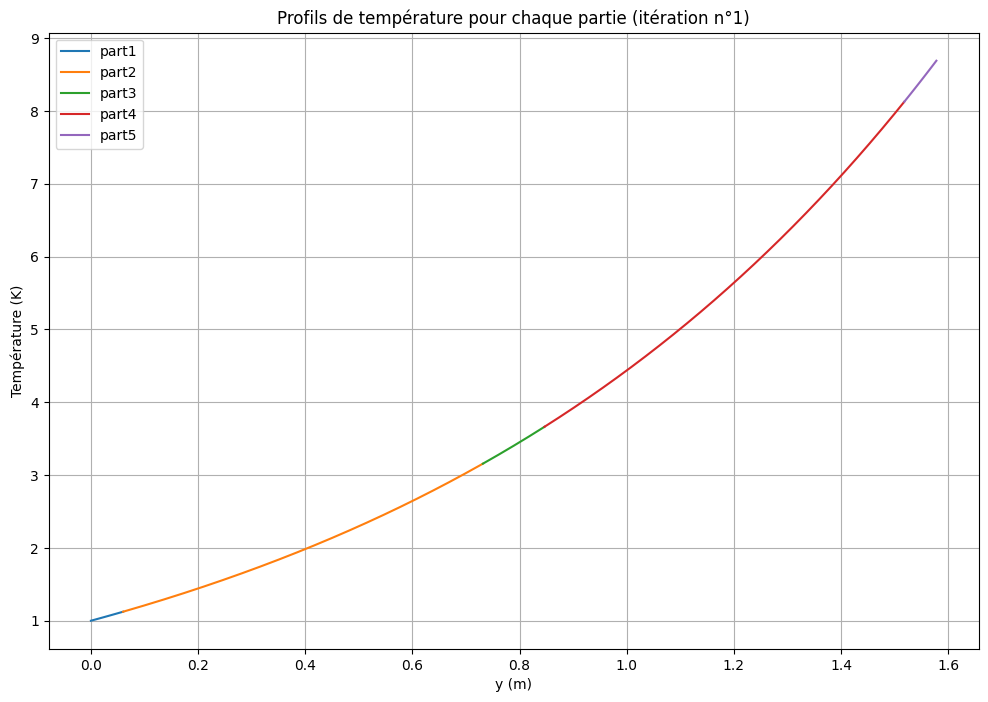

In [6]:
# Fonctions pour calculer les températures
def T_fluid_fct(y_values, T_fluid_in, a_f, b_f):
    return (T_fluid_in + b_f / a_f) * np.exp(a_f * y_values) - b_f / a_f

# Récupération du pas de discrétisation

step = Inputs.loc[Inputs['named_expression'] == 'L_1']['value'].values[0] / 100

# Listes pour stocker les profils de température

temperature_profiles = []  # Contient le profil de température pour chaque partie
T_fluid_values_tot = [apb.get_value('T_fluid_in_1', 'named_expression', Inputs)]
y_values_tot = [0]

for i in range(1, nb_hx + 1):
    T_fluid_in = apb.get_value(f'T_fluid_in_{i}', 'named_expression', Inputs)
    L = apb.get_value(f'L_{i}', 'named_expression', Inputs)
    a_f = apb.get_value(f'a_f_{i}', 'named_expression', Inputs)
    b_f = apb.get_value(f'b_f_{i}', 'named_expression', Inputs)


    # Calcul de la température de sortie du fluide pour la partie suivante
    T_fluid_out_value = apb.T_fluid_out(T_fluid_in, L, a_f, b_f)
    #if i < nb_hx:
    Inputs.loc[Inputs['named_expression'] == f'T_fluid_in_{i+1}', 'value'] = T_fluid_out_value

    # Discrétisation et calcul des valeurs de température
    y_values = np.linspace(y_values_tot[-1], y_values_tot[-1] + L, int(L / step))
    T_fluid_values = T_fluid_fct(y_values - y_values_tot[-1], T_fluid_in, a_f, b_f)

    temperature_profiles.append((y_values, T_fluid_values, f'part{i}'))
    y_values_tot = np.concatenate((y_values_tot, y_values[1:]))  # Exclure le premier point car déjà inclus
    T_fluid_values_tot = np.concatenate((T_fluid_values_tot, T_fluid_values[1:]))  # Exclure le premier point car déjà inclus


# Tracé des courbes avec Matplotlib

cmap = get_cmap('tab10')  # Choix de la colormap
plt.figure(figsize=(12, 8))

for y_values, T_fluid_values, part in temperature_profiles:
    plt.plot(y_values, T_fluid_values, label=part)

plt.xlabel('y (m)')
plt.ylabel('Température (K)')
plt.title('Profils de température pour chaque partie (itération n°1)')
plt.legend()
plt.grid(True)
plt.show()